In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import glob
import os
import json
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [56]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASSED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed)

In [49]:
os.listdir('../input/cassava-leaf-disease-classification/')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [64]:
df_train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df_test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
df_train.head(2)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3


In [65]:
path = '../input/cassava-leaf-disease-classification/'
df_train['image_id'] = df_train['image_id'].apply(lambda x: path + 'train_images/' + x)
df_test['image_id'] = df_test['image_id'].apply(lambda x: path + 'test_images/' + x)
df_train.head(2)

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3


In [86]:
X = df_train['image_id']
y = df_train['label']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y)

X_test = df_test['image_id']

In [67]:
X_valid

7296     ../input/cassava-leaf-disease-classification/t...
2268     ../input/cassava-leaf-disease-classification/t...
5        ../input/cassava-leaf-disease-classification/t...
8512     ../input/cassava-leaf-disease-classification/t...
2567     ../input/cassava-leaf-disease-classification/t...
                               ...                        
7612     ../input/cassava-leaf-disease-classification/t...
8815     ../input/cassava-leaf-disease-classification/t...
18312    ../input/cassava-leaf-disease-classification/t...
4171     ../input/cassava-leaf-disease-classification/t...
1456     ../input/cassava-leaf-disease-classification/t...
Name: image_id, Length: 6420, dtype: object

## Dataset

In [84]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((resize, resize)),
                transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(mean, std)
            ]), 
            'val': transforms.Compose([
                transforms.Resize((resize, resize)), 
                transforms.ToTensor(), 
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        if phase == 'test':
            phase = 'val'
        return self.data_transform[phase](img)

In [69]:
os.listdir('../input/cassava-leaf-disease-classification/')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

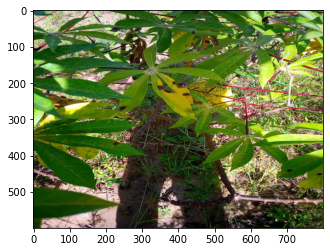

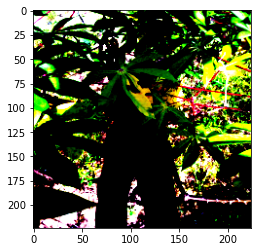

In [72]:
img = Image.open(X_train[0])

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, 'train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [73]:
def make_datapath_list(phase='train'):
    
    rootpath = '../input/cassava-leaf-disease-classification/'
    target_path = os.path.join(rootpath + phase + '_images/' + '*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [74]:
train_list = make_datapath_list(phase='train')
test_list = make_datapath_list(phase='test')

../input/cassava-leaf-disease-classification/train_images/*.jpg
../input/cassava-leaf-disease-classification/test_images/*.jpg


In [91]:
class CassavaDataset(data.Dataset):
    
    def __init__(self, transform, X, y=None, phase='train'):
#         self.file_list = file_list  # the list of filepath
        self.transform = transform  # ImageTransfomer
        self.df_train = df_train
        self.df_test = df_test
        self.phase = phase    # train or val or test
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
#         path = '../input/cassava-leaf-disease-classification/'
#         img_path = self.file_list[index]
#         img = Image.open(path + self.phase + '_images/'+ img_path)  # [Hight][Width][RGB]
        img = Image.open(X[index])
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == 'train' or self.phase == 'val':
            label = y[index]
            return img_transformed, label
            
        elif self.phase == 'test':
            return img_transformed

In [92]:
train_dataset = CassavaDataset(transform=ImageTransform(size, mean, std), 
                               X = X_train, 
                               y = y_train, 
                               phase = 'train')

valid_dataset = CassavaDataset(transform=ImageTransform(size, mean, std), 
                               X = X_valid, 
                               y = y_valid, 
                               phase = 'val')

test_dataset = CassavaDataset(transform=ImageTransform(size, mean, std), 
                              X = X_test, 
                              phase = 'test')

In [98]:
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(valid_dataset.__getitem__(index)[0].size())
print(valid_dataset.__getitem__(index)[1])
print(train_dataset.__getitem__(index)[0].size())

torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
